# DRUMS - COVASIM Data Generation

In [1]:
import sys
sys.path.append('../')
from drums_data_gen import *
# from drums_data_gen_multi import *
import Modules.Loaders.DataFormatter as DF
from Modules.Utils.Imports import *

Covasim 3.1.3 (2022-07-19) — © 2020-2022 by IDM


c:\Users\Teddy\anaconda3\envs\reu_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def to_torch(ndarray):
    arr = torch.tensor(ndarray, dtype=torch.float)
    arr.requires_grad_(True)
    arr = arr.to(device)
    return arr

def to_numpy(x):
    return x.detach().cpu().numpy()

device = torch.device(GetLowestGPU(pick_from=[0,1,2,3]))

Device set to cpu


- `drums_gata_gen` generates data for one simulation.
- `drums_data_gen_multi` generates data for multiple simulations and averages over the results.

***

- `test_prob`: This is a float value that corresponds to the probability of testing given the agent is symptomatic. Currently, the values for proabbility of testing for other scenarios are `asymp_prob=0.001`, `symp_quar_prob=0.3`, and `asymp_quar_prob=0.3`. Additionally, the policy for quarantining is `quar_policy='daily'`
- `trace_lb` and `trace_ub`: These float values correspond to the lower and upper bounds on probability of tracing. Currently, the trace probability for the layers are `h=1.0`, `s=0.5`, `w=0.5`, `c=0.3`.
- `chi_type`: The type of the function that interacts with the tracing probability. Can choose between `constant`, `linear`, `piecewise`, and `sin`.
- `dynamic`: Boolean value that indicates whether or not to include the interacting term/function.
- `keep_d`: Boolean value that indicates wehter or not to include the D - diagnosed compartments.
- `model_params:` Dictionary containing keys pointing to parameter values, the compartment model's values over the simulation, and more.

In [3]:
population = int(200e3)
test_prob = 0.1
trace_lb = 0.0
trace_ub = 0.3
chi_type = 'piecewise'
keep_d = True
dynamic = True
maskb = True
multiple = False
n_runs = 2
model_params = ModelParams(population, test_prob, trace_lb, trace_ub, chi_type, keep_d, dynamic, maskb)

Initializing sim with 200000 people for 182 days
  Running 2020-02-01 ( 0/182) (2.24 s)  ———————————————————— 1%
  Running 2020-02-11 (10/182) (3.34 s)  •——————————————————— 6%
  Running 2020-02-21 (20/182) (4.71 s)  ••—————————————————— 11%
  Running 2020-03-02 (30/182) (6.05 s)  •••————————————————— 17%
  Running 2020-03-12 (40/182) (7.56 s)  ••••———————————————— 22%
  Running 2020-03-22 (50/182) (9.15 s)  •••••——————————————— 28%
  Running 2020-04-01 (60/182) (10.83 s)  ••••••—————————————— 33%
  Running 2020-04-11 (70/182) (12.55 s)  •••••••————————————— 39%
  Running 2020-04-21 (80/182) (14.28 s)  ••••••••———————————— 44%
  Running 2020-05-01 (90/182) (16.07 s)  •••••••••——————————— 50%
  Running 2020-05-11 (100/182) (17.91 s)  •••••••••••————————— 55%
  Running 2020-05-21 (110/182) (19.57 s)  ••••••••••••———————— 61%
  Running 2020-05-31 (120/182) (21.16 s)  •••••••••••••——————— 66%
  Running 2020-06-10 (130/182) (22.63 s)  ••••••••••••••—————— 72%
  Running 2020-06-20 (140/182) 

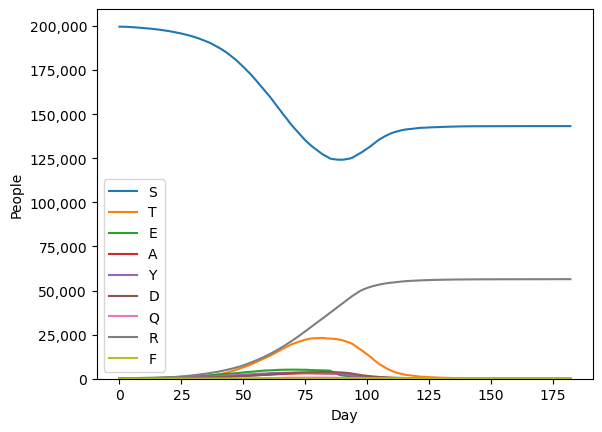

In [5]:
drums_data_generator(model_params)
# drums_data_generator_multi(model_params, n_runs)

In [6]:
path = '../Data/covasim_data/drums_data/'
retrain = False
case_name = get_case_name(population, test_prob, trace_ub, keep_d, dynamic=dynamic, chi_type=chi_type)

if multiple:
    params = DF.load_covasim_data(path, population, test_prob, trace_ub, keep_d, case_name + '_' + str(n_runs), plot=True)
else:
    params = DF.load_covasim_data(path, population, test_prob, trace_ub, keep_d, case_name, plot=True)

In [7]:
if multiple:
    data = np.mean(params['data'], axis=0)
    data = (data / params['population'])
else:
    data = params['data']
    data = (data / params['population']).to_numpy()

params.pop('data')
N = len(data)
t = np.arange(N)[:,None]

In [9]:
# rescale data values to represent number of people in state X rather than ratios
data *= population

plot=True
if plot:
    n = data.shape[1]
    col_names = list('STEAYDQRF') if keep_d else list('STEAYQRF')
    # plot compartments
    fig = plt.figure(figsize=(15, 15))
    
    if multiple:
        for i in range(1, n + 1):
            ax = fig.add_subplot(int(np.ceil(n / 3)), 3, i)
            ax.plot(t, data[:, i - 1], '.k', label='Covasim Data')
            ax.set_title(col_names[i - 1])
            ax.legend(fontsize=8)
            fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
            plt.tight_layout(pad=2)
            plt.savefig(os.path.join(path, case_name + '_' + str(n_runs) + '_avg' + '.png') )
            # plt.show()
    else:
        for i in range(1, n + 1):
            ax = fig.add_subplot(int(np.ceil(n / 3)), 3, i)
            ax.plot(t, data[:, i - 1], '.k', label='Covasim Data')
            ax.set_title(col_names[i - 1])
            ax.legend(fontsize=8)
            fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
            plt.tight_layout(pad=2)
            plt.savefig(os.path.join(path, case_name + '_single' + '.png') )
            # plt.show()